# **Tutorial** - Topic Modeling with BERTransfer

<img src="https://raw.githubusercontent.com/Pclanglais/BERTransfer/main/BERTransfer.png" alt="Bertransfer logo"  width="200"/>

This demo shows how BERTransfer can be used to transfer the classification of a dataset of twitter texts to a new dataset. Topics extracted from a collection of top 25,000 tweets in English from October 2022 will be reapplied to a similar collection of 25,000 tweets from November 2022.

BERTransfer is based on **BERTopic**, a topic modeling technique that leverages 🤗 transformers and a custom class-based TF-IDF to create dense clusters allowing for easily interpretable topics whilst keeping important words in the topic descriptions. BERTransfer makes it possible to reuse topics defined by BERTopic on one corpus to further corpora. 

BERTransfer is especially useful for continuous observations on new data (for instance to track the evolution of online conversation). It also makes it possible to store and reuse annotated interpreted models that can take some time to create.

# Enabling the GPU

First, you'll need to enable GPUs for the notebook:

- Navigate to Edit→Notebook Settings
- select GPU from the Hardware Accelerator drop-down

[Reference](https://colab.research.google.com/notebooks/gpu.ipynb)

# **Installing BERTransfer**

We start by installing BERTransfer from Github, which will also proceed to install BERTopics.

In [ ]:
!python -m pip install git+https://github.com/opinionscience/BERTransfer.git

Optionally you may have to ensure that the code runs well in UTF-8 (some of the text included in the corpus will not be in ASCII):

In [ ]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

# Loading the corpus
We are going to connect to Drive in order to store the output of classification.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd "/content/drive/My Drive/Colab Notebooks"

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks


This demonstration is based on the top most retweeted tweets in English in October 2022. This extract provide a very diverse selection of potential topics: politics, news, pop culture, sports… We will first load it from Github along with the subsequent similar dataset from November 2022.

In [ ]:
!wget https://github.com/Pclanglais/English-Top-Tweets/blob/main/top_retweet_2022_october.tsv?raw=true -O "top_retweet_2022_october.tsv"
!wget https://github.com/Pclanglais/English-Top-Tweets/blob/main/top_retweet_2022_november.tsv?raw=true -O "top_retweet_2022_november.tsv"

--2023-04-05 13:49:37--  https://github.com/Pclanglais/English-Top-Tweets/blob/main/top_retweet_2022_october.tsv?raw=true
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/Pclanglais/English-Top-Tweets/raw/main/top_retweet_2022_october.tsv [following]
--2023-04-05 13:49:37--  https://github.com/Pclanglais/English-Top-Tweets/raw/main/top_retweet_2022_october.tsv
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Pclanglais/English-Top-Tweets/main/top_retweet_2022_october.tsv [following]
--2023-04-05 13:49:37--  https://raw.githubusercontent.com/Pclanglais/English-Top-Tweets/main/top_retweet_2022_october.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.git

We open the textual dataset and inspect its first rows:

In [ ]:
import pandas as pd
import re

file_id = "top_retweet_2022_october"

dataset = pd.read_csv(file_id + '.tsv', sep='\t')

dataset = dataset.astype('string')

dataset

url  \
0      http://twitter.com/i/web/status/15759989939095...   
1      http://twitter.com/i/web/status/15759990361546...   
2      http://twitter.com/i/web/status/15759991498659...   
3      http://twitter.com/i/web/status/15759993670097...   
4      http://twitter.com/i/web/status/15759996853025...   
...                                                  ...   
24995  http://twitter.com/i/web/status/15877584354370...   
24996  http://twitter.com/i/web/status/15877593632841...   
24997  http://twitter.com/i/web/status/15877596694722...   
24998  http://twitter.com/i/web/status/15877636631084...   
24999  http://twitter.com/i/web/status/15877768026419...   

                                                    text  \
0      blep 🎃 https://twitter.com/Abigail_Larson/stat...   
1            the “A” in her name stands for anger issues   
2      just found the coolest picture of me ever take...   
3      Spot the difference #HouseOfTheDragon https://...   
4      Me leaving behind all my work responsibilities...   
...                                                  ...   
24995    $50 GIVEAWAY IN 12HOURS  RT & Follow @SirKunt 🔔   
24996  $50 | 750.000 IDR ~ 24 HOURS  RT like & follow...   
24997                      $100 in 60 Minutes   ☑️RT + 🔔   
24998  $100 | 1.5 JT • 12 Hours 💜  - RT & Follow  @m0...   
24999  It’s so lovely to live in front of the sea…..t...   

                 local_time retweet_count like_count reply_count  
0      2022-10-01T00:00:15Z          6428      37636          38  
1      2022-10-01T00:00:25Z         12664      55864         310  
2      2022-10-01T00:00:52Z         17549     224430         966  
3      2022-10-01T00:01:44Z          6785      69759         195  
4      2022-10-01T00:03:00Z         10372      54286         244  
...                     ...           ...        ...         ...  
24995  2022-11-02T10:48:04Z          6719       1457        1911  
24996  2022-11-02T10:51:46Z          5892       5036        1532  
24997  2022-11-02T10:52:59Z          7354       1688        2993  
24998  2022-11-02T11:08:51Z          5870       1376        1462  
24999  2022-11-02T12:01:03Z          7727      39991        2285  

[25000 rows x 6 columns]

We do a bit of cleaning to remove potential noise in the tweet text

In [ ]:
dataset.text = dataset.apply(lambda row: re.sub(r"http\S+", "", str(row.text)).lower(), 1)
dataset.text = dataset.apply(lambda row: re.sub(r"_p_", "", str(row.text)).lower(), 1)
dataset.text = dataset.apply(lambda row: " ".join(filter(lambda x:x[0]!="@", row.text.split())), 1)
dataset.text = dataset.apply(lambda row: " ".join(re.sub("[^a-zA-Zàâäéèêëïîôöùûüÿçß]+", " ", row.text).split()), 1)
dataset = dataset.loc[(dataset.text != ""), :]

We store the identifier of the documents and the text as individual python list. **ids** store the unique ids of each document (in this case an url). **text** stores the text inside each document.

In [ ]:
ids = dataset['url'].tolist()
docs = dataset['text'].tolist()

# **Basic creation of topic models**

In this section we will identify unsupervised topics from our initial corpus using the "create_bertopic" function. It is to a large extent an overlay of the BERTopic function. 

The classification will take some time (usually around 10 minutes for a corpus of this size).




In [ ]:
from BERTransfer import create_bertopic

bertopic_model = create_bertopic(ids = ids, docs = docs, language = "english")

2023-04-05 13:53:07,691 - BERTopic - Reduced dimensionality
2023-04-05 13:59:10,947 - BERTopic - Clustered reduced embeddings


At the end you will obtain a Python object containing a lot of additional information.

In [ ]:
bertopic_model

A BERTopic model with 469 topics and 24997 documents.

bertopic_model contain two key datasets to document the topic model. First, the datasets of topics that contain, for each topics, a list of characteristic words and characteristic documents.

In [ ]:
bertopic_model.topic_dataset

topic_id                   topic_name meta_topic  \
0          0         covid_vaccine_pfizer          0   
1          1            elon_musk_twitter          0   
2          2            pelosi_nancy_paul          0   
3          3           jungkook_jung_joon          1   
4          4         democracy_vote_polls          2   
..       ...                          ...        ...   
463      463  hunter_biden_administration          0   
464      464  lesbian_international_happy         41   
465      465       giveaway_rt_reflitepro         23   
466      466          light_darkest_spark         36   
467      467  year_thekidfromakron_peaked         20   

                                            topic_word topic_size  \
0    covid (4.0), vaccine (3.0), pfizer (2.0), vacc...        211   
1    elon (4.0), musk (3.0), twitter (3.0), speech ...        250   
2    pelosi (4.0), nancy (3.0), paul (3.0), speaker...        155   
3    jungkook (13.0), jung (3.0), joon (1.0), jungk...        139   
4    democracy (2.0), vote (2.0), polls (2.0), elec...        240   
..                                                 ...        ...   
463  hunter (10.0), biden (4.0), administration (3....         43   
464  lesbian (40.0), international (27.0), happy (2...         25   
465  giveaway (13.0), rt (10.0), reflitepro (8.0), ...         31   
466  light (11.0), darkest (11.0), spark (9.0), shi...         14   
467  year (20.0), thekidfromakron (15.0), peaked (1...         26   

                                                 doc_1  \
0    http://twitter.com/i/web/status/15876060248313...   
1    http://twitter.com/i/web/status/15760223009100...   
2    http://twitter.com/i/web/status/15860986823650...   
3    http://twitter.com/i/web/status/15802873273433...   
4    http://twitter.com/i/web/status/15836724204722...   
..                                                 ...   
463  http://twitter.com/i/web/status/15783865388026...   
464  http://twitter.com/i/web/status/15767695569407...   
465  http://twitter.com/i/web/status/15876602440664...   
466  http://twitter.com/i/web/status/15770704468889...   
467  http://twitter.com/i/web/status/15763211109199...   

                                                 doc_2  \
0    http://twitter.com/i/web/status/15776103165102...   
1    http://twitter.com/i/web/status/15857872745410...   
2    http://twitter.com/i/web/status/15807126907667...   
3    http://twitter.com/i/web/status/15787269485486...   
4    http://twitter.com/i/web/status/15792851563675...   
..                                                 ...   
463  http://twitter.com/i/web/status/15854279443104...   
464  http://twitter.com/i/web/status/15786206920815...   
465  http://twitter.com/i/web/status/15848147105115...   
466  http://twitter.com/i/web/status/15781153714035...   
467  http://twitter.com/i/web/status/15770117804629...   

                                                 doc_3  \
0    http://twitter.com/i/web/status/15798017277251...   
1    http://twitter.com/i/web/status/15859934164999...   
2    http://twitter.com/i/web/status/15867193599885...   
3    http://twitter.com/i/web/status/15819283895058...   
4    http://twitter.com/i/web/status/15796347676956...   
..                                                 ...   
463  http://twitter.com/i/web/status/15766151308291...   
464  http://twitter.com/i/web/status/15841969790849...   
465  http://twitter.com/i/web/status/15852078956246...   
466  http://twitter.com/i/web/status/15789963731935...   
467  http://twitter.com/i/web/status/15772278680816...   

                                                 doc_4  \
0    http://twitter.com/i/web/status/15788867085478...   
1    http://twitter.com/i/web/status/15859661912138...   
2    http://twitter.com/i/web/status/15866187298820...   
3    http://twitter.com/i/web/status/15802882142034...   
4    http://twitter.com/i/web/status/15809618780327...   
..                                                 ...   
463  

Secondly the datasets of **documents** with for each document the most likely topic and their associated probability.

In [ ]:
bertopic_model.document_dataset

url  \
0      http://twitter.com/i/web/status/15759989939095...   
1      http://twitter.com/i/web/status/15759990361546...   
3      http://twitter.com/i/web/status/15759993670097...   
4      http://twitter.com/i/web/status/15759996853025...   
5      http://twitter.com/i/web/status/15760001238924...   
...                                                  ...   
35690  http://twitter.com/i/web/status/15877584354370...   
35691  http://twitter.com/i/web/status/15877593632841...   
35693  http://twitter.com/i/web/status/15877596694722...   
35695  http://twitter.com/i/web/status/15877636631084...   
35696  http://twitter.com/i/web/status/15877768026419...   

                              topic_name  topic  probability  main_topic  
0                           bts_run_fool     14        100.0          14  
1                         she_her_erased     29          6.0          29  
3      houseofthedragon_daemon_targaryen      9         38.0           9  
4                     jisoo_fashion_liar    292        100.0         292  
5         hello_thesecondstep_chaptertwo     39         14.0          39  
...                                  ...    ...          ...         ...  
35690           giveaway_overborne_hours    450        100.0         450  
35691                   idr_hours_follow    180         40.0         180  
35693                    mins_idr_follow    355          4.0          -1  
35695                       jt_follow_rt     74         80.0          74  
35696                birthday_happy_eula     95          2.0          -1  

[20222 rows x 5 columns]

bertopic_model also contains the **embeddings** of the topic, or basically their semantic signature within BERT. The embeddings will be instrumental to perform the transfer of topics from one corpus to another.

In [ ]:
bertopic_model.topic_embeddings

{'14': array([-6.0028090e+00, -3.1486070e+00,  3.6461496e-01, -6.2732613e-01,
         6.3002791e+00,  8.9714819e-01,  6.5944819e+00,  1.5787967e+00,
        -1.9424477e+00, -4.2778167e-01, -2.4675307e+00, -2.2712467e+00,
         3.5649409e+00, -8.2443100e-01,  3.0164583e+00,  6.8531446e+00,
         1.7641895e+00, -1.0797126e+01, -4.1332808e+00, -3.4228823e+00,
        -7.2192659e+00,  2.5913537e+00,  4.3909198e-01,  7.6375289e+00,
        -4.6373453e+00, -9.4979525e-01,  3.1574900e+00, -2.5376511e+00,
        -1.8537395e-02, -2.9710789e+00, -3.4974756e+00,  1.5662894e+00,
         1.1061791e+00, -2.8483734e+00, -1.7771907e+00, -2.3206768e+00,
         3.1874380e+00,  3.1229751e+00, -1.4034430e+00, -3.4481881e+00,
        -4.1751995e+00, -7.6364312e+00, -1.8668098e+00, -4.1736484e-01,
         4.9450345e+00,  1.0923823e+00, -2.1331637e+00, -1.0134348e+00,
         2.3838305e+00,  6.2744781e-02,  4.7669396e+00, -1.6245996e+00,
        -2.3726933e+00,  5.6948390e+00, -6.2100248e+00,  2

Then we can save the result on the Drive directory. We also define a project_name, that will be root name for all the subsequent files. This part of the code is not run since for reproducibility purposes we will rather reuse a unique run (with BERTopic the topics will be different each time).

In [ ]:
#bertopic_model.save_results(project_name = "twitter_2022_october")

# **Advanced creation of topic models**

More parameters are included to fit with more potential use cases.

In [ ]:
bertopic_model = create_bertopic(ids, docs, language = "english", bert_model = "all-MiniLM-L6-v2", similarity_threshold = 0.01, document_selection = 20)

2023-04-05 14:28:50,351 - BERTopic - Reduced dimensionality
2023-04-05 14:35:04,521 - BERTopic - Clustered reduced embeddings


**all-MiniLM-L6-v2** is the default model used by BERTopic but alternative models can be provided as well. all-MiniLM-L6-v2 is based on a set of question and answers from Reddit and will optimize the identification of semantic classification.

the **similarity_threshold** is a minimal rate of similarity between a topic and a document that is retained to keep the document in the document dataset.

the **document selection** is the number of characteristic documents kept for each topic in the topic dataset

Finally there is an option to include larger topics called *meta_topics*:

In [ ]:
bertopic_model = create_bertopic(ids, docs, language = "english", bert_model = "all-MiniLM-L6-v2", similarity_threshold = 0.01, document_selection = 20, add_meta_topics = True)

2023-04-05 14:38:15,690 - BERTopic - Reduced dimensionality
2023-04-05 14:44:30,245 - BERTopic - Clustered reduced embeddings


The meta_topics will now be included in the dataset of topics:

In [ ]:
bertopic_model.topic_dataset

topic_id                       topic_name meta_topic  \
0          0                pelosi_nancy_paul          0   
1          1                elon_musk_twitter          1   
2          2           ukraine_russia_russian         -1   
3          3        halloween_costume_dressed          2   
4          4             covid_vaccine_pfizer          3   
..       ...                              ...        ...   
450      450            monkeys_monkey_tarzan         38   
451      451             porn_intruder_titles         14   
452      452                uglier_miche_ugly         11   
453      453  antibiotics_mccullough_stripped          3   
454      454                   phone_app_dies         48   

                                            topic_word topic_size  \
0    pelosi (4.0), nancy (2.0), paul (2.0), speaker...        164   
1    elon (4.0), musk (4.0), twitter (3.0), speech ...        248   
2    ukraine (4.0), russia (3.0), russian (2.0), pu...        161   
3    halloween (11.0), costume (5.0), dressed (2.0)...        213   
4    covid (4.0), vaccine (3.0), pfizer (2.0), tran...        192   
..                                                 ...        ...   
450  monkeys (21.0), monkey (15.0), tarzan (11.0), ...         35   
451  porn (38.0), intruder (15.0), titles (12.0), t...         13   
452  uglier (6.0), miche (6.0), ugly (6.0), bitch (...         81   
453  antibiotics (6.0), mccullough (4.0), stripped ...         42   
454  phone (14.0), app (10.0), dies (9.0), kronmei ...         17   

                                                 doc_1  \
0    http://twitter.com/i/web/status/15810489290088...   
1    http://twitter.com/i/web/status/15760223009100...   
2    http://twitter.com/i/web/status/15786757088761...   
3    http://twitter.com/i/web/status/15864080906391...   
4    http://twitter.com/i/web/status/15788867085478...   
..                                                 ...   
450  http://twitter.com/i/web/status/15765981099329...   
451  http://twitter.com/i/web/status/15771087803909...   
452  http://twitter.com/i/web/status/15760655263164...   
453  http://twitter.com/i/web/status/15812495582222...   
454  http://twitter.com/i/web/status/15821786568639...   

                                                 doc_2  \
0    http://twitter.com/i/web/status/15860823498252...   
1    http://twitter.com/i/web/status/15858163823814...   
2    http://twitter.com/i/web/status/15830072690628...   
3    http://twitter.com/i/web/status/15783692070198...   
4    http://twitter.com/i/web/status/15780983933015...   
..                                                 ...   
450  http://twitter.com/i/web/status/15864191429867...   
451  http://twitter.com/i/web/status/15777779649299...   
452  http://twitter.com/i/web/status/15866504228228...   
453  http://twitter.com/i/web/status/15822256407905...   
454  http://twitter.com/i/web/status/15820752170019...   

                                                 doc_3  \
0    http://twitter.com/i/web/status/15867409570007...   
1    http://twitter.com/i/web/status/15792640484197...   
2    http://twitter.com/i/web/status/15794055861561...   
3    http://twitter.com/i/web/status/15869917931615...   
4    http://twitter.com/i/web/status/15845354049123...   
..                                                 ...   
450  http://twitter.com/i/web/status/15861596339110...   
451  http://twitter.com/i/web/status/15824318883541...   
452  http://twitter.com/i/web/status/15831532060998...   
453  http://twitter.com/i/web/status/15864362956221...   
454  http://twitter.com/i/web/status/15832533010299...   

                                                 doc_4  \
0    http://twitter.com/i/web/status/15869075289774...   
1    http://twitter.com/i/web/status/15798861362433...   
2    http://twitter.com/i/web/status/15857293419917...   
3    http://twitter.com/i/web/status/15871098865670...   
4    http://twitter.com/i/web/status/15789829754708...   
..             

# **Topic transfer**

In this section we showcase the transfer of the topic defined on our first set from October 2022 to the new set of Novembre 2022. 

This process will be significantly quicker, since we directly use the embeddings produced by sentence transformer without the additional data processing of BERTopic. That's also what makes it more practical when dealing with large amount of data

First we load supplementary files so that we will get the same results.

In [ ]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [ ]:
!wget https://github.com/Pclanglais/English-Top-Tweets/blob/main/topics_twitter_2022_october.tsv?raw=true -O "topics_twitter_2022_october.tsv"
!wget https://github.com/Pclanglais/English-Top-Tweets/blob/main/topics_twitter_2022_october_documented.tsv?raw=true -O "topics_twitter_2022_october_documented.tsv"
!wget https://github.com/Pclanglais/English-Top-Tweets/blob/main/topics_twitter_2022_october.pkl?raw=true -O "topics_twitter_2022_october.pkl"
!wget https://github.com/Pclanglais/English-Top-Tweets/blob/main/documents_twitter_2022_october.tsv?raw=true -O "documents_twitter_2022_october.tsv"

--2023-04-05 14:49:38--  https://github.com/Pclanglais/English-Top-Tweets/blob/main/topics_twitter_2022_october.tsv?raw=true
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/Pclanglais/English-Top-Tweets/raw/main/topics_twitter_2022_october.tsv [following]
--2023-04-05 14:49:39--  https://github.com/Pclanglais/English-Top-Tweets/raw/main/topics_twitter_2022_october.tsv
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Pclanglais/English-Top-Tweets/main/topics_twitter_2022_october.tsv [following]
--2023-04-05 14:49:39--  https://raw.githubusercontent.com/Pclanglais/English-Top-Tweets/main/topics_twitter_2022_october.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connec

First we open the dataset of November 2022

In [ ]:
import pandas as pd
import re

file_id = "top_retweet_2022_november"
dataset = pd.read_csv(file_id + '.tsv', sep='\t')
dataset = dataset.astype('string')
dataset

url  \
0      http://twitter.com/i/web/status/15872180335206...   
1      http://twitter.com/i/web/status/15872184841776...   
2      http://twitter.com/i/web/status/15872185392361...   
3      http://twitter.com/i/web/status/15872190025138...   
4      http://twitter.com/i/web/status/15872192409306...   
...                                                  ...   
24995  http://twitter.com/i/web/status/15961300108212...   
24996  http://twitter.com/i/web/status/15961300563296...   
24997  http://twitter.com/i/web/status/15961445979229...   
24998  http://twitter.com/i/web/status/15961493050560...   
24999  http://twitter.com/i/web/status/15961567561614...   

                                                    text  \
0      🚨𝐌𝐢𝐧𝐭 𝐡𝐚𝐬 𝐬𝐭𝐚𝐫𝐭𝐞𝐝🚨  'Mint button’ retired🗿  Im...   
1      $25 | Ends in 1 Hours   🟩 RT & RT and Like to ...   
2      back for a minute. i’m bi. congrats for forcin...   
3      Public service announcement for whoever needs ...   
4      The looming mofumofu is too cute. https://twit...   
...                                                  ...   
24995  (cont.) I'm so sorry... Chuu unnie's heart is ...   
24996  BREAKING: Congress members reportedly tried to...   
24997  Asian countries in the World Cup https://twitt...   
24998  [#2022ENniversary] 🏫 221125 CHOREOGRAPHY VIDEO...   
24999  A very happy birthday (November 26) to Satoshi...   

                 local_time retweet_count like_count reply_count  
0      2022-10-31T23:00:42Z          3367       3371          86  
1      2022-10-31T23:02:30Z          3385        568         799  
2      2022-10-31T23:02:43Z         74522     970338       38979  
3      2022-10-31T23:04:33Z          3387      22892         214  
4      2022-10-31T23:05:30Z         23087     160901         760  
...                     ...           ...        ...         ...  
24995  2022-11-25T13:13:43Z          3670      13248          32  
24996  2022-11-25T13:13:54Z          3844      14075        2216  
24997  2022-11-25T14:11:41Z          6124      51337         369  
24998  2022-11-25T14:30:24Z         13968      33322         950  
24999  2022-11-25T15:00:00Z          7507      24966         199  

[25000 rows x 6 columns]

We also do a bit of cleaning to remove potential noise in the tweet text

In [ ]:
dataset.text = dataset.apply(lambda row: re.sub(r"http\S+", "", str(row.text)).lower(), 1)
dataset.text = dataset.apply(lambda row: re.sub(r"_p_", "", str(row.text)).lower(), 1)
dataset.text = dataset.apply(lambda row: " ".join(filter(lambda x:x[0]!="@", row.text.split())), 1)
dataset.text = dataset.apply(lambda row: " ".join(re.sub("[^a-zA-Zàâäéèêëïîôöùûüÿçß]+", " ", row.text).split()), 1)
dataset = dataset.loc[(dataset.text != ""), :]

And we define the list of ids and texts for the classification.

In [ ]:
ids = dataset['url'].tolist()
docs = dataset['text'].tolist()

Then we need to load the previous topic modeling model. As it names shows, topic_embeddings is just the set of topic embeddings that we have created from the set of October 2022.

In [ ]:
import pickle
a_file = open("topics_twitter_2022_october.pkl", "rb")
topic_embeddings = pickle.load(a_file)

Now we are ready to run the main function. It works similarly to create_bertopic, except that we also pass the set of topic embeddings.

In [ ]:
from BERTransfer import create_bertransfer

bertransfer_model = create_bertransfer(ids, docs, topic_embeddings = topic_embeddings, language = "english", min_cosine_distance = 0.5)

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

There's also a new indicators **min_cosine_distance** which is basically the threshold of proximity needed to associate a document to a topic. You can also think of it as a likelyhood of the document to belong to a topic. 0.5 is a fairly low requirement and to ensure better results you can pass a higher threshold: this would also result in having a larger share of the new database not being classified.

Now we can inspect the model object

In [ ]:
bertransfer_model

A BERTransfer model with 474 topics and 24998 documents.

We can retrieve the document dataset with this attribute:

In [ ]:
bertransfer_model.document_dataset

topic_id document_id                                                url  \
0           19       18663  http://twitter.com/i/web/status/15943477820217...   
1           19       11547  http://twitter.com/i/web/status/15920618849994...   
2           19       15209  http://twitter.com/i/web/status/15934372408979...   
3           19       18028  http://twitter.com/i/web/status/15941987241499...   
4           19       18197  http://twitter.com/i/web/status/15942384328883...   
...        ...         ...                                                ...   
28557      213        1293  http://twitter.com/i/web/status/15874405720542...   
28559      213       24506  http://twitter.com/i/web/status/15958179514871...   
28560      213        1350  http://twitter.com/i/web/status/15874481217721...   
28566      213        1052  http://twitter.com/i/web/status/15874187671806...   
28567      213        1131  http://twitter.com/i/web/status/15874242141636...   

       cosine_distance  
0             0.780992  
1             0.768947  
2             0.761099  
3             0.759192  
4             0.759192  
...                ...  
28557         0.529271  
28559         0.522249  
28560         0.516174  
28566         0.506222  
28567         0.506172  

[13128 rows x 4 columns]

There is not topic dataset as it is basically the same as the previous one. It's also possible to reconcile the classification on this topic dataset to have interpretable names for topic with the document topic function.

In [ ]:
bertransfer_model.document_topic("topics_twitter_2022_october.tsv")

topic_id              topic_name  meta_topic  \
0             0    covid_vaccine_pfizer           1   
1             0    covid_vaccine_pfizer           1   
2             0    covid_vaccine_pfizer           1   
3             0    covid_vaccine_pfizer           1   
4             0    covid_vaccine_pfizer           1   
...         ...                     ...         ...   
13120       471  artists_chimmy_forever          39   
13121       471  artists_chimmy_forever          39   
13122       471  artists_chimmy_forever          39   
13123       471  artists_chimmy_forever          39   
13124       471  artists_chimmy_forever          39   

                                              topic_word document_id  \
0      covid (4.0), vaccine (3.0), pfizer (2.0), vacc...       23558   
1      covid (4.0), vaccine (3.0), pfizer (2.0), vacc...       23329   
2      covid (4.0), vaccine (3.0), pfizer (2.0), vacc...       23974   
3      covid (4.0), vaccine (3.0), pfizer (2.0), vacc...       10974   
4      covid (4.0), vaccine (3.0), pfizer (2.0), vacc...       11344   
...                                                  ...         ...   
13120  artists (16.0), chimmy (10.0), forever (9.0), ...       24745   
13121  artists (16.0), chimmy (10.0), forever (9.0), ...       24078   
13122  artists (16.0), chimmy (10.0), forever (9.0), ...       19965   
13123  artists (16.0), chimmy (10.0), forever (9.0), ...       19932   
13124  artists (16.0), chimmy (10.0), forever (9.0), ...        3678   

                                                     url  cosine_distance  
0      http://twitter.com/i/web/status/15955157218737...         0.780687  
1      http://twitter.com/i/web/status/15954667466845...         0.758695  
2      http://twitter.com/i/web/status/15956375740762...         0.743408  
3      http://twitter.com/i/web/status/15918332114952...         0.712823  
4      http://twitter.com/i/web/status/15919366997346...         0.712122  
...                                                  ...              ...  
13120  http://twitter.com/i/web/status/15958811246135...         0.546708  
13121  http://twitter.com/i/web/status/15956669008221...         0.534464  
13122  http://twitter.com/i/web/status/15945868116824...         0.530638  
13123  http://twitter.com/i/web/status/15945710144527...         0.513101  
13124  http://twitter.com/i/web/status/15883228262345...         0.506339  

[13125 rows x 7 columns]

This function is also very practical when you have annotated the topics defined on the previous corpus.

In [ ]:
bertransfer_model.document_topic("topics_twitter_2022_october_documented.tsv").dropna()

category    Thematic  topic_id            topic_name  \
0       Midterm elections    Politics         8  democracy_polls_vote   
1       Midterm elections    Politics         8  democracy_polls_vote   
2       Midterm elections    Politics         8  democracy_polls_vote   
3       Midterm elections    Politics         8  democracy_polls_vote   
4       Midterm elections    Politics         8  democracy_polls_vote   
...                   ...         ...       ...                   ...   
3616  Emotion/sensitivity  Daily life       144  sensitive_upset_hurt   
3617  Emotion/sensitivity  Daily life       144  sensitive_upset_hurt   
3618  Emotion/sensitivity  Daily life       144  sensitive_upset_hurt   
3619  Emotion/sensitivity  Daily life       144  sensitive_upset_hurt   
3620  Emotion/sensitivity  Daily life       144  sensitive_upset_hurt   

      meta_topic                                         topic_word  \
0              7  democracy (2.0), polls (2.0), vote (2.0), ball...   
1              7  democracy (2.0), polls (2.0), vote (2.0), ball...   
2              7  democracy (2.0), polls (2.0), vote (2.0), ball...   
3              7  democracy (2.0), polls (2.0), vote (2.0), ball...   
4              7  democracy (2.0), polls (2.0), vote (2.0), ball...   
...          ...                                                ...   
3616          -1  sensitive (5.0), upset (3.0), hurt (2.0), noti...   
3617          -1  sensitive (5.0), upset (3.0), hurt (2.0), noti...   
3618          -1  sensitive (5.0), upset (3.0), hurt (2.0), noti...   
3619          -1  sensitive (5.0), upset (3.0), hurt (2.0), noti...   
3620          -1  sensitive (5.0), upset (3.0), hurt (2.0), noti...   

     document_id                                                url  \
0           3006  http://twitter.com/i/web/status/15879545500104...   
1           3325  http://twitter.com/i/web/status/15881762968988...   
2           4905  http://twitter.com/i/web/status/15889637508494...   
3             71  http://twitter.com/i/web/status/15872312756554...   
4           1653  http://twitter.com/i/web/status/15874873276765...   
...          ...                                                ...   
3616        4548  http://twitter.com/i/web/status/15887386684619...   
3617        3064  http://twitter.com/i/web/status/15879759913806...   
3618       19918  http://twitter.com/i/web/status/15945643675967...   
3619       14630  http://twitter.com/i/web/status/15933288916447...   
3620       23053  http://twitter.com/i/web/status/15954139248574...   

      cosine_distance  
0            0.711740  
1            0.689575  
2            0.678009  
3            0.674127  
4            0.673947  
...               ...  
3616         0.514186  
3617         0.513571  
3618         0.511710  
3619         0.510130  
3620         0.508358  

[3422 rows x 9 columns]

We can quickly compare the distribution of topics with a seaborn dataviz

In [ ]:
pd.read_csv('documents_twitter_2022_october.tsv', sep='\t')

url  \
0      http://twitter.com/i/web/status/15759989939095...   
1      http://twitter.com/i/web/status/15759993670097...   
2      http://twitter.com/i/web/status/15759996853025...   
3      http://twitter.com/i/web/status/15760001238924...   
4      http://twitter.com/i/web/status/15760019077218...   
...                                                  ...   
20720  http://twitter.com/i/web/status/15877584354370...   
20721  http://twitter.com/i/web/status/15877593632841...   
20722  http://twitter.com/i/web/status/15877596694722...   
20723  http://twitter.com/i/web/status/15877636631084...   
20724  http://twitter.com/i/web/status/15877768026419...   

                             topic_name  topic  probability  main_topic  
0                          bts_run_fool     19         23.0          19  
1      houseofthedragon_daemon_rhaenyra      5         12.0           5  
2                    jisoo_maria_diorss    350         40.0         350  
3        hello_thesecondstep_chaptertwo     59          5.0          59  
4                 nato_sanctions_starve    448          2.0          -1  
...                                 ...    ...          ...         ...  
20720             giveaway_hours_follow     78        100.0          78  
20721                  idr_hours_follow    158        100.0         158  
20722            minutes_touch_physical    225        100.0         225  
20723                      jt_follow_rt     65        100.0          65  
20724            birthday_happy_prabhas     11         10.0          11  

[20725 rows x 5 columns]

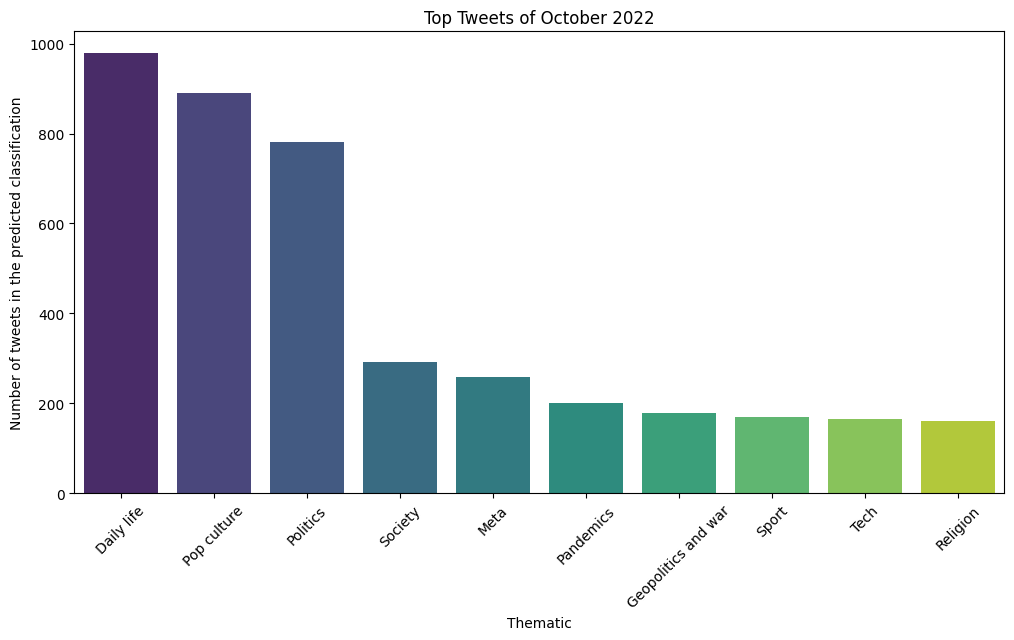

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('documents_twitter_2022_october.tsv', sep='\t')
df = df.rename(columns={'topic': 'topic_id'})

df = df.merge(pd.read_csv('topics_twitter_2022_october_documented.tsv', sep='\t'), on = "topic_id").dropna()

# Count the unique occurrences in the category column
category_counts = df['Thematic'].value_counts()

# Visualize the unique occurrences using a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x=category_counts.index, y=category_counts.values, palette='viridis')
plt.xlabel('Thematic')
plt.ylabel('Number of tweets in the predicted classification')
plt.title('Top Tweets of October 2022')
plt.xticks(rotation=45)
plt.show()

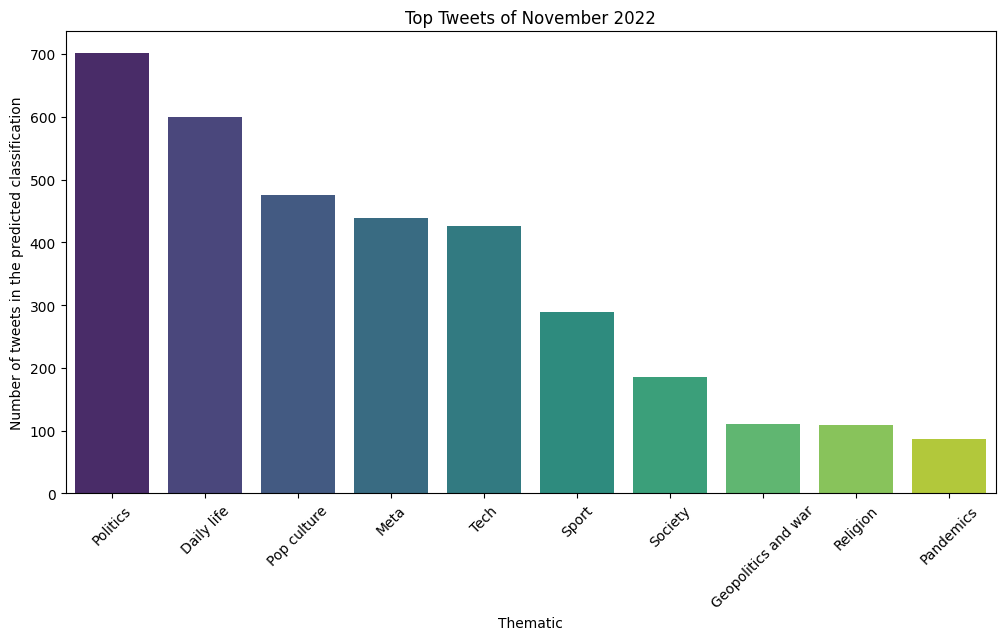

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

df = bertransfer_model.document_topic("topics_twitter_2022_october_documented.tsv").dropna()

# Count the unique occurrences in the category column
category_counts = df['Thematic'].value_counts()

# Visualize the unique occurrences using a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x=category_counts.index, y=category_counts.values, palette='viridis')
plt.xlabel('Thematic')
plt.ylabel('Number of tweets in the predicted classification')
plt.title('Top Tweets of November 2022')
plt.xticks(rotation=45)
plt.show()

Politics is much more prevalent which makes sense since the elections occurred on November 2022.